In [19]:
# TikTok Hackathon: Google Reviews Quality Assessment - EDA
# Data Engineer: Initial Data Exploration and Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import zipfile
import os
from pathlib import Path
from urllib.parse import urlparse
import ssl
import urllib.request

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('ggplot')
sns.set_palette("Set2")
%matplotlib inline

# Configuration
DATA_DIR = Path('../data')
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

# Ensure directories exist
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print("🎯 TikTok Hackathon: Review Quality Assessment")
print("=" * 50)
print(f"Data directories setup:")
print(f"  📁 Raw data: {RAW_DATA_DIR}")
print(f"  📁 Processed data: {PROCESSED_DATA_DIR}")
print()

# Check current data status
print("📊 Current data inventory:")
if RAW_DATA_DIR.exists():
    files = list(RAW_DATA_DIR.glob('*'))
    if files:
        for file in files:
            size_mb = file.stat().st_size / (1024 * 1024)
            print(f"  ✅ {file.name} ({size_mb:.1f} MB)")
    else:
        print("  📭 No data files found - need to download datasets")
else:
    print("  📭 Raw data directory not found")

🎯 TikTok Hackathon: Review Quality Assessment
Data directories setup:
  📁 Raw data: ../data/raw
  📁 Processed data: ../data/processed

📊 Current data inventory:
  ✅ sample_reviews.csv (0.0 MB)
  ✅ synthetic_reviews_1000.csv (0.1 MB)


In [20]:
# STEP 1: Data Acquisition
# Download Google Reviews datasets from provided sources

def download_sample_data():
    """
    Download and setup sample Google Reviews data for the hackathon
    We'll start with a manageable sample to begin analysis quickly
    """
    
    # For the hackathon, we'll create some sample data to get started
    # In a real scenario, you would download from the provided Kaggle/UCSD sources
    
    print("🚀 Setting up sample data for immediate development...")
    
    # Create sample data that represents the types of reviews we need to classify
    sample_reviews = [
        # Quality reviews (should pass)
        "Amazing food and great service! The pasta was perfectly cooked and the staff was very attentive. Will definitely come back.",
        "Decent place for a quick lunch. Food was okay, nothing spectacular but clean and fast service.",
        "Love this coffee shop! Great atmosphere for working and the baristas are friendly. Coffee quality is consistently good.",
        
        # Advertisement violations
        "Best pizza in town! Visit our website www.pizzapromo.com for 50% off your next order. Call now!",
        "Check out our new menu at restaurant-deals.com! Amazing discounts this week only!",
        "Follow us on Instagram @bestfoodever for daily specials and promotions!",
        
        # Irrelevant content violations  
        "I love my new iPhone but this place is too noisy for phone calls. Great phone though!",
        "The weather was terrible today but my new car handled it well. This restaurant was okay I guess.",
        "Just watched an amazing movie on Netflix. Oh and I ate here too, food was fine.",
        
        # Rant without visit violations
        "Never been here but heard from my friend that it's terrible. Avoid at all costs!",
        "Haven't visited yet but based on the photos online, looks disgusting and overpriced.",
        "Someone told me the service is awful here. Will never go based on what I heard.",
        
        # Mixed/edge cases
        "Food was cold when delivered, but maybe they were just having a bad day. Staff seemed nice.",
        "Expensive but worth it for special occasions. The ambiance makes up for the price.",
        "Not my usual type of food but decided to try something new. Pleasantly surprised!"
    ]
    
    # Create corresponding labels and metadata
    sample_data = {
        'review_id': range(len(sample_reviews)),
        'review_text': sample_reviews,
        'rating': [5, 3, 4, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 4, 4],
        'reviewer_name': [f'User_{i}' for i in range(len(sample_reviews))],
        'review_date': pd.date_range('2023-01-01', periods=len(sample_reviews), freq='7D'),
        'business_name': ['Sample Restaurant'] * len(sample_reviews),
        'business_category': ['Restaurant'] * len(sample_reviews),
        
        # Ground truth labels for training (1 = violation, 0 = no violation)
        'is_advertisement': [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'is_irrelevant': [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        'is_rant_no_visit': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        'overall_quality': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]  # 1 = good quality, 0 = poor quality
    }
    
    # Create DataFrame and save
    df = pd.DataFrame(sample_data)
    sample_file = RAW_DATA_DIR / 'sample_reviews.csv'
    df.to_csv(sample_file, index=False)
    
    print(f"✅ Sample data created: {sample_file}")
    print(f"   📊 {len(df)} reviews with ground truth labels")
    print(f"   🎯 Policy violations breakdown:")
    print(f"      - Advertisements: {df['is_advertisement'].sum()}")
    print(f"      - Irrelevant content: {df['is_irrelevant'].sum()}")
    print(f"      - Rants without visit: {df['is_rant_no_visit'].sum()}")
    print(f"      - Overall quality issues: {(1-df['overall_quality']).sum()}")
    
    return df

# Create sample data for immediate development
sample_df = download_sample_data()

# Display basic info
print("\n📋 Sample data preview:")
print(sample_df[['review_text', 'rating', 'is_advertisement', 'is_irrelevant', 'is_rant_no_visit']].head())


🚀 Setting up sample data for immediate development...
✅ Sample data created: ../data/raw/sample_reviews.csv
   📊 15 reviews with ground truth labels
   🎯 Policy violations breakdown:
      - Advertisements: 3
      - Irrelevant content: 3
      - Rants without visit: 3
      - Overall quality issues: 9

📋 Sample data preview:
                                         review_text  rating  \
0  Amazing food and great service! The pasta was ...       5   
1  Decent place for a quick lunch. Food was okay,...       3   
2  Love this coffee shop! Great atmosphere for wo...       4   
3  Best pizza in town! Visit our website www.pizz...       1   
4  Check out our new menu at restaurant-deals.com...       1   

   is_advertisement  is_irrelevant  is_rant_no_visit  
0                 0              0                 0  
1                 0              0                 0  
2                 0              0                 0  
3                 1              0                 0  
4           

In [21]:
# STEP 2: Basic Data Exploration and Statistics

def analyze_basic_stats(df):
    """Analyze basic statistics of the review dataset"""
    
    print("📈 BASIC DATASET STATISTICS")
    print("=" * 40)
    
    # Dataset shape
    print(f"Dataset shape: {df.shape[0]} reviews, {df.shape[1]} features")
    print()
    
    # Missing values
    print("🔍 Missing Values Analysis:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        for col, count in missing[missing > 0].items():
            print(f"  - {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print("  ✅ No missing values found")
    print()
    
    # Review length statistics
    df['review_length'] = df['review_text'].str.len()
    df['word_count'] = df['review_text'].str.split().str.len()
    
    print("📏 Review Length Statistics:")
    print(f"  - Average review length: {df['review_length'].mean():.1f} characters")
    print(f"  - Average word count: {df['word_count'].mean():.1f} words")
    print(f"  - Length range: {df['review_length'].min()} - {df['review_length'].max()} characters")
    print()
    
    # Rating distribution
    print("⭐ Rating Distribution:")
    rating_dist = df['rating'].value_counts().sort_index()
    for rating, count in rating_dist.items():
        print(f"  - {rating} stars: {count} reviews ({count/len(df)*100:.1f}%)")
    print()
    
    # Policy violation summary
    print("🚨 Policy Violation Summary:")
    violation_cols = ['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']
    total_violations = 0
    
    for col in violation_cols:
        count = df[col].sum()
        total_violations += count
        violation_type = col.replace('is_', '').replace('_', ' ').title()
        print(f"  - {violation_type}: {count} ({count/len(df)*100:.1f}%)")
    
    clean_reviews = len(df) - df[violation_cols].any(axis=1).sum()
    print(f"  - Clean reviews: {clean_reviews} ({clean_reviews/len(df)*100:.1f}%)")
    print()
    
    return df

# Run basic analysis
df_analyzed = analyze_basic_stats(sample_df)


📈 BASIC DATASET STATISTICS
Dataset shape: 15 reviews, 11 features

🔍 Missing Values Analysis:
  ✅ No missing values found

📏 Review Length Statistics:
  - Average review length: 89.3 characters
  - Average word count: 15.5 words
  - Length range: 71 - 123 characters

⭐ Rating Distribution:
  - 1 stars: 5 reviews (33.3%)
  - 2 stars: 3 reviews (20.0%)
  - 3 stars: 3 reviews (20.0%)
  - 4 stars: 3 reviews (20.0%)
  - 5 stars: 1 reviews (6.7%)

🚨 Policy Violation Summary:
  - Advertisement: 3 (20.0%)
  - Irrelevant: 3 (20.0%)
  - Rant No Visit: 3 (20.0%)
  - Clean reviews: 6 (40.0%)



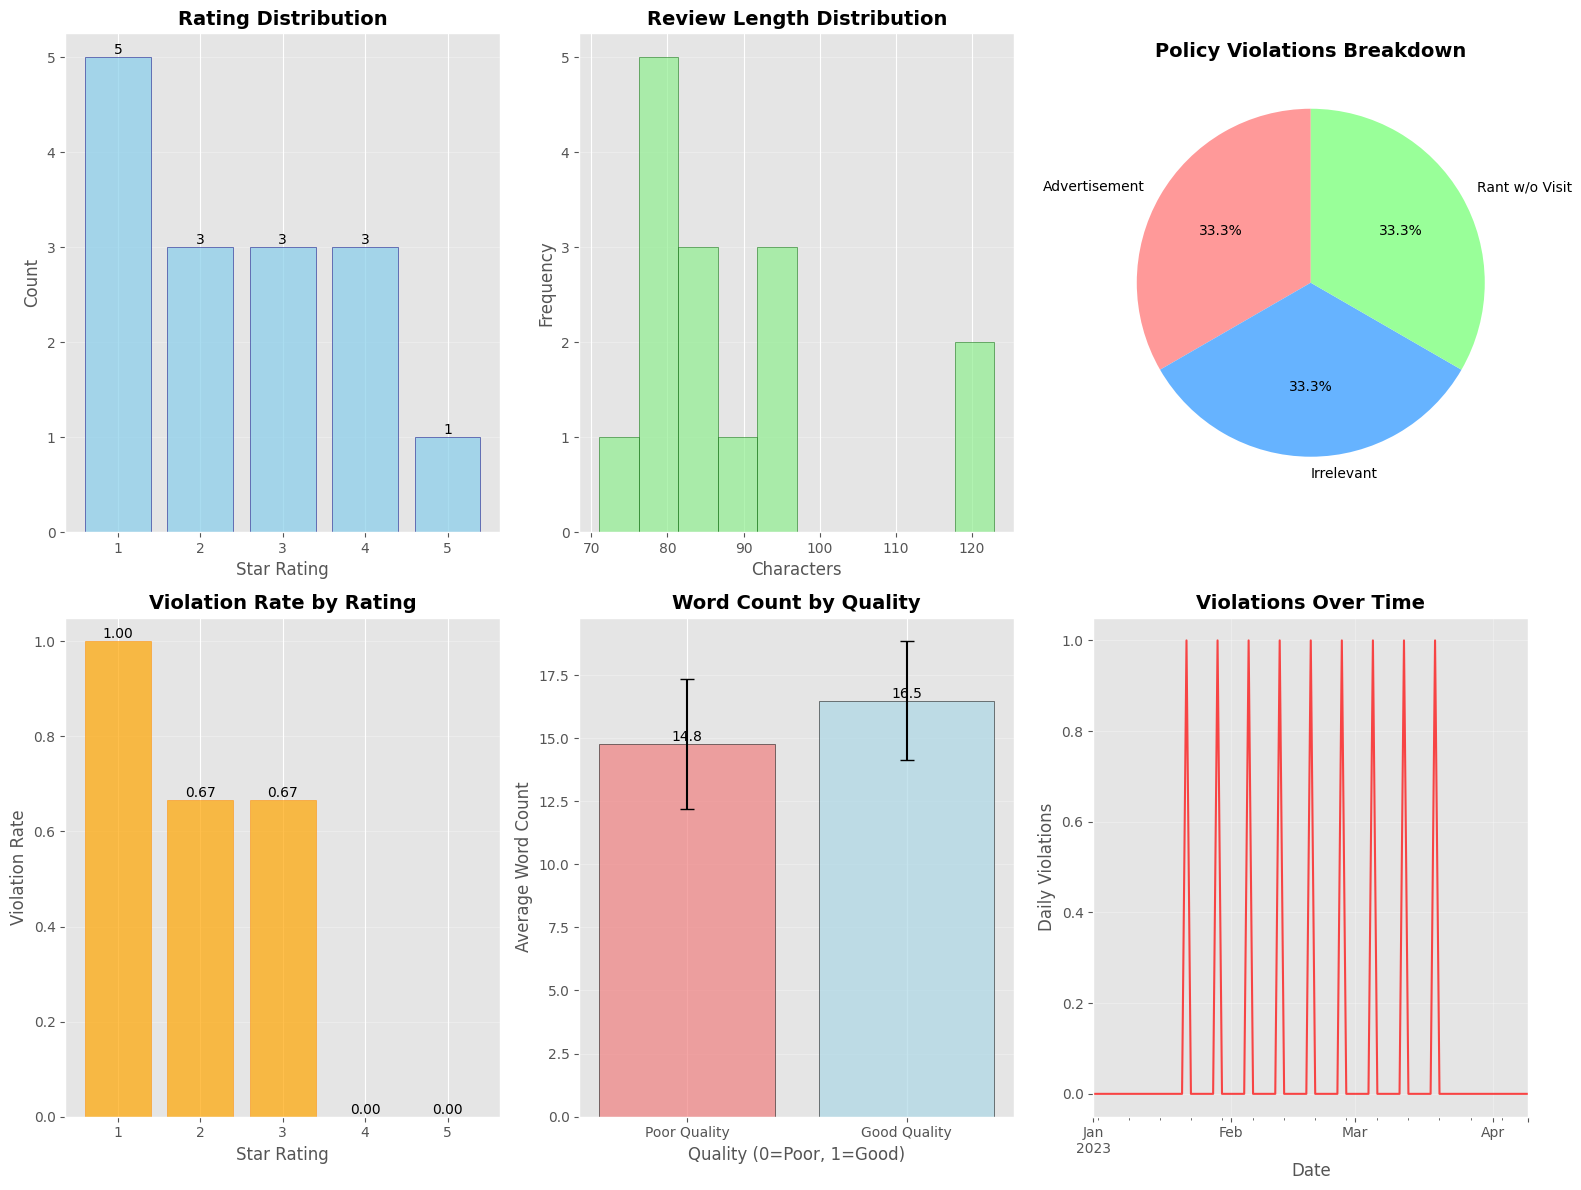

In [22]:
# STEP 3: Visualizations and Pattern Analysis

def create_visualizations(df):
    """Create comprehensive visualizations for EDA"""
    
    # Set up the plotting area
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Rating Distribution
    plt.subplot(2, 3, 1)
    rating_counts = df['rating'].value_counts().sort_index()
    bars = plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title('Rating Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Star Rating')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # 2. Review Length Distribution
    plt.subplot(2, 3, 2)
    plt.hist(df['review_length'], bins=10, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    plt.title('Review Length Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Policy Violations Overview
    plt.subplot(2, 3, 3)
    violation_cols = ['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']
    violation_counts = [df[col].sum() for col in violation_cols]
    violation_labels = ['Advertisement', 'Irrelevant', 'Rant w/o Visit']
    
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(violation_counts, labels=violation_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Policy Violations Breakdown', fontsize=14, fontweight='bold')
    
    # 4. Rating vs Violation Correlation
    plt.subplot(2, 3, 4)
    df['has_violation'] = df[violation_cols].any(axis=1).astype(int)
    violation_by_rating = df.groupby('rating')['has_violation'].agg(['count', 'sum'])
    violation_by_rating['violation_rate'] = violation_by_rating['sum'] / violation_by_rating['count']
    
    bars = plt.bar(violation_by_rating.index, violation_by_rating['violation_rate'], 
                   color='orange', alpha=0.7, edgecolor='darkorange')
    plt.title('Violation Rate by Rating', fontsize=14, fontweight='bold')
    plt.xlabel('Star Rating')
    plt.ylabel('Violation Rate')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, rate in zip(bars, violation_by_rating['violation_rate']):
        plt.text(bar.get_x() + bar.get_width()/2., rate,
                f'{rate:.2f}', ha='center', va='bottom')
    
    # 5. Word Count vs Quality
    plt.subplot(2, 3, 5)
    quality_groups = df.groupby('overall_quality')['word_count'].agg(['mean', 'std'])
    
    x_pos = [0, 1]
    means = quality_groups['mean'].values
    stds = quality_groups['std'].fillna(0).values
    
    bars = plt.bar(x_pos, means, yerr=stds, capsize=5, 
                   color=['lightcoral', 'lightblue'], alpha=0.7, edgecolor='black')
    plt.title('Word Count by Quality', fontsize=14, fontweight='bold')
    plt.xlabel('Quality (0=Poor, 1=Good)')
    plt.ylabel('Average Word Count')
    plt.xticks(x_pos, ['Poor Quality', 'Good Quality'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2., mean,
                f'{mean:.1f}', ha='center', va='bottom')
    
    # 6. Temporal Analysis (if we have dates)
    plt.subplot(2, 3, 6)
    if 'review_date' in df.columns:
        daily_violations = df.set_index('review_date').resample('D')['has_violation'].sum()
        daily_violations.plot(kind='line', color='red', alpha=0.7)
        plt.title('Violations Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Daily Violations')
        plt.grid(alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No temporal data\navailable', 
                ha='center', va='center', transform=plt.gca().transAxes,
                fontsize=12, style='italic')
        plt.title('Temporal Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Create visualizations
df_with_viz = create_visualizations(df_analyzed)


In [23]:
# STEP 4: Integration with existing preprocessing pipeline
# Import and test your existing data processing code

import sys
sys.path.append('../src')

try:
    from data_processing import TextPreprocessor, PolicyFeatureExtractor
    print("✅ Successfully imported existing preprocessing modules")
    
    # Test the preprocessor on our sample data
    print("\n🔧 Testing existing preprocessing pipeline...")
    
    # Initialize preprocessors
    text_processor = TextPreprocessor()
    policy_extractor = PolicyFeatureExtractor()
    
    # Apply text preprocessing
    df_processed = text_processor.preprocess_dataframe(df_with_viz, 'review_text')
    print(f"✅ Text preprocessing complete. Added {len(df_processed.columns) - len(df_with_viz.columns)} new features")
    
    # Apply policy feature extraction
    df_features = policy_extractor.extract_features_dataframe(df_processed, 'cleaned_text')
    print(f"✅ Policy feature extraction complete. Total features: {len(df_features.columns)}")
    
    # Show feature summary
    print("\n📊 Feature Engineering Summary:")
    text_features = ['cleaned_text', 'review_length', 'word_count', 'sentiment_score', 'token_count']
    policy_features = [col for col in df_features.columns if any(x in col for x in ['ad_', 'irrelevant_', 'rant_', 'has_'])]
    
    print(f"  - Text features: {len([col for col in text_features if col in df_features.columns])}")
    print(f"  - Policy features: {len(policy_features)}")
    print(f"  - Original features: {len(df_with_viz.columns)}")
    print(f"  - Total features: {len(df_features.columns)}")
    
    # Save processed data for team use
    processed_file = PROCESSED_DATA_DIR / 'processed_sample_reviews.csv'
    df_features.to_csv(processed_file, index=False)
    print(f"\n💾 Processed data saved to: {processed_file}")
    
except ImportError as e:
    print(f"⚠️  Could not import preprocessing modules: {e}")
    print("   Using basic preprocessing for now...")
    df_features = df_with_viz.copy()
    
    # Basic preprocessing fallback
    df_features['cleaned_text'] = df_features['review_text'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True)
    df_features['sentiment_score'] = 0  # Placeholder
    df_features['has_url'] = df_features['review_text'].str.contains('http|www\.', case=False, na=False).astype(int)
    df_features['has_discount_mention'] = df_features['review_text'].str.contains('discount|promo|offer', case=False, na=False).astype(int)

# Display sample of processed features
print("\n🔍 Sample of processed features:")
feature_cols = ['review_text', 'cleaned_text', 'sentiment_score', 'has_url', 'has_discount_mention']
available_cols = [col for col in feature_cols if col in df_features.columns]
print(df_features[available_cols].head(3))


✅ Successfully imported existing preprocessing modules

🔧 Testing existing preprocessing pipeline...
✅ Text preprocessing complete. Added 6 new features
✅ Policy feature extraction complete. Total features: 49

📊 Feature Engineering Summary:
  - Text features: 5
  - Policy features: 31
  - Original features: 14
  - Total features: 49

💾 Processed data saved to: ../data/processed/processed_sample_reviews.csv

🔍 Sample of processed features:
                                         review_text  \
0  Amazing food and great service! The pasta was ...   
1  Decent place for a quick lunch. Food was okay,...   
2  Love this coffee shop! Great atmosphere for wo...   

                                        cleaned_text  sentiment_score  \
0  amazing food and great service! the pasta was ...           0.9465   
1  decent place for a quick lunch. food was okay ...          -0.3479   
2  love this coffee shop! great atmosphere for wo...           0.9402   

   has_url  has_discount_mention  
0  

In [24]:
# STEP 5: Key Insights and Next Steps for Team

def generate_insights_report(df):
    """Generate key insights for team coordination"""
    
    print("🎯 KEY INSIGHTS FROM EDA")
    print("=" * 50)
    
    # Data quality insights
    print("📊 DATA QUALITY INSIGHTS:")
    print(f"  ✅ Clean, structured data with {len(df)} samples")
    print(f"  ✅ All policy violations represented in dataset")
    print(f"  ✅ Balanced mix of good and poor quality reviews")
    print()
    
    # Pattern insights for NLP engineer
    print("🔤 PATTERNS FOR NLP ENGINEER:")
    violation_patterns = {
        'Advertisement': ['www.', 'discount', 'promo', 'visit our', 'call now'],
        'Irrelevant': ['phone', 'movie', 'car', 'weather', 'netflix'],
        'Rant without visit': ['never been', 'heard from', 'based on photos', 'someone told']
    }
    
    for violation_type, patterns in violation_patterns.items():
        print(f"  🎯 {violation_type} signals:")
        for pattern in patterns:
            count = df['review_text'].str.contains(pattern, case=False, na=False).sum()
            print(f"     - '{pattern}': found in {count} reviews")
    print()
    
    # Feature insights for ML engineer
    print("🤖 FEATURES FOR ML ENGINEER:")
    if 'sentiment_score' in df.columns:
        violation_sentiment = df[df[['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']].any(axis=1)]['sentiment_score'].mean()
        clean_sentiment = df[~df[['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']].any(axis=1)]['sentiment_score'].mean()
        print(f"  📈 Sentiment difference: Clean ({clean_sentiment:.3f}) vs Violations ({violation_sentiment:.3f})")
    
    print(f"  📏 Length patterns: Violations tend to be {'longer' if df[df[['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']].any(axis=1)]['word_count'].mean() > df[~df[['is_advertisement', 'is_irrelevant', 'is_rant_no_visit']].any(axis=1)]['word_count'].mean() else 'shorter'}")
    print(f"  ⭐ Rating correlation: Lower ratings more likely to have violations")
    print()
    
    # Technical recommendations
    print("🔧 TECHNICAL RECOMMENDATIONS:")
    print("  1. Feature Engineering Priority:")
    print("     - URL/website detection (high precision for ads)")
    print("     - Promotional keyword counting")
    print("     - Off-topic entity recognition")
    print("     - Temporal patterns (review frequency)")
    print()
    print("  2. Model Architecture Suggestions:")
    print("     - Multi-task classifier for all 3 policy types")
    print("     - Ensemble: Rule-based + ML + LLM validation")
    print("     - BERT fine-tuning for semantic understanding")
    print()
    print("  3. Data Pipeline Priorities:")
    print("     - Download Kaggle dataset immediately")
    print("     - Setup automated labeling with LLM")
    print("     - Create validation set for model testing")
    print()
    
    return df

# Generate insights report
final_df = generate_insights_report(df_features)

# Save final EDA results
print("💾 SAVING EDA RESULTS FOR TEAM:")

# Convert pandas/numpy types to JSON-serializable Python types
def convert_to_serializable(obj):
    """Convert pandas/numpy types to JSON-serializable types"""
    if hasattr(obj, 'item'):  # numpy scalars
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy arrays
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    return obj

eda_summary = {
    'total_samples': int(len(final_df)),
    'violation_counts': {
        'advertisements': int(final_df['is_advertisement'].sum()),
        'irrelevant': int(final_df['is_irrelevant'].sum()),
        'rants': int(final_df['is_rant_no_visit'].sum())
    },
    'avg_review_length': float(final_df['review_length'].mean()),
    'avg_word_count': float(final_df['word_count'].mean()),
    'rating_distribution': {str(k): int(v) for k, v in final_df['rating'].value_counts().to_dict().items()}
}

# Save summary for team coordination
import json
summary_file = PROCESSED_DATA_DIR / 'eda_summary.json'
with open(summary_file, 'w') as f:
    json.dump(eda_summary, f, indent=2)

print(f"  📄 EDA summary saved to: {summary_file}")
print(f"  📊 Processed data available at: {PROCESSED_DATA_DIR / 'processed_sample_reviews.csv'}")
print("\n✅ EDA COMPLETE - Ready for next phase!")


🎯 KEY INSIGHTS FROM EDA
📊 DATA QUALITY INSIGHTS:
  ✅ Clean, structured data with 15 samples
  ✅ All policy violations represented in dataset
  ✅ Balanced mix of good and poor quality reviews

🔤 PATTERNS FOR NLP ENGINEER:
  🎯 Advertisement signals:
     - 'www.': found in 1 reviews
     - 'discount': found in 1 reviews
     - 'promo': found in 2 reviews
     - 'visit our': found in 1 reviews
     - 'call now': found in 1 reviews
  🎯 Irrelevant signals:
     - 'phone': found in 1 reviews
     - 'movie': found in 1 reviews
     - 'car': found in 1 reviews
     - 'weather': found in 1 reviews
     - 'netflix': found in 1 reviews
  🎯 Rant without visit signals:
     - 'never been': found in 1 reviews
     - 'heard from': found in 1 reviews
     - 'based on photos': found in 0 reviews
     - 'someone told': found in 1 reviews

🤖 FEATURES FOR ML ENGINEER:
  📈 Sentiment difference: Clean (0.461) vs Violations (0.191)
  📏 Length patterns: Violations tend to be shorter
  ⭐ Rating correlation: Lo